# CHSH simulation via IBM Quantum to accompany [arXiv:2205.01262](https://arxiv.org/abs/2205.01262)

<b>Note: </b> [Qiskit](https://qiskit.org/) must be installed for this to run on a local device. An [IBM Quantum](https://www.ibm.com/quantum) account (free) is required to use quantum hardware, but simulations can be performed with [Qiskit](https://qiskit.org/).

In [ ]:
from qiskit import *
import numpy as np
from matplotlib import pyplot as plt

Alice and Charlie each select one from a set of operators to measure. Each operator can be represented by a computational basis measurement after rotating the qubit by spherical angles $(-\phi,-\theta)$. Twelve combinations are used.

With the measurement configuration selected randomly, the basic scheme is to run each of the 12 cases for a large number of shots within a single job. Basic error mitigation is performed by bundling the appropriate number of calibration circuits into the job. 

In [2]:
thet2a = np.pi/2
phi2a = 0.0

thet3a = np.pi/2
phi3a = np.pi/2

thet1a = 0.0
phi1a = 0.0

thet1b = np.pi/4
phi1b = 0.0

thet2b = -np.pi/4
phi2b = 0.0

thet3b = np.pi/4
phi3b = np.pi/2

thet4b = np.pi/4
phi4b = -np.pi/2

thet5b = np.pi/2
phi5b = np.pi/4

thet6b = np.pi/2
phi6b = -np.pi/4

angles = np.array([[phi1a,thet1a,phi1b,thet1b],[phi1a,thet1a,phi2b,thet2b],[phi2a,thet2a,phi1b,thet1b],[phi2a,thet2a,phi2b,thet2b],[phi1a,thet1a,phi3b,thet3b],[phi1a,thet1a,phi4b,thet4b],[phi3a,thet3a,phi3b,thet3b],[phi3a,thet3a,phi4b,thet4b],[phi2a,thet2a,phi5b,thet5b],[phi2a,thet2a,phi6b,thet6b],[phi3a,thet3a,phi5b,thet5b],[phi3a,thet3a,phi6b,thet6b]])

In [4]:
circs = []
phi1_vals = angles[:,0]
theta1_vals = angles[:,1]
phi2_vals = angles[:,2]
theta2_vals = angles[:,3]

for i in range(0,12):
    #qubits used
    qb = [0,1,2,3]
    
    qr = QuantumRegister(5,'q')
    cr = ClassicalRegister(4,'c')
    circ = QuantumCircuit(qr,cr)

    circ.h(qb[0])
    circ.cnot(qb[0],qb[1])

    circ.h(qb[2])
    circ.cnot(qb[2],qb[3])

    circ.barrier(qr)

    circ.cnot(qb[1],qb[2])
    circ.h(qb[1])

    circ.barrier(qr)


    circ.rz(-phi1_vals[i],qb[0])
    circ.ry(-theta1_vals[i],qb[0])

    circ.rz(-phi2_vals[i],qb[3])
    circ.ry(-theta2_vals[i],qb[3])

    circ.measure(qb,cr)
    
    circs.append(circ)


Error mitigation (calibration) circuits. For a four-qubit system, each of the states $|0000\rangle$, $|0001\rangle$, $\cdots$, $|1111\rangle$ is created and measured. From the noisy counts, a calibration matrix can be constructed.

In [5]:
def mitigation_circ(N):
    Ncirc = 2**N
    circlist = []
    
    for i in range(0,Ncirc):
        qr = QuantumRegister(5)
        cr = ClassicalRegister(N)
        qb = [0,1,2,3]
        
        circ = QuantumCircuit(qr,cr)
        
        x = format(i, "b")
        
        while (len(x)<N):
            x = '0'+x
            
        for j in range(0,N):
            if (x[j]=='1'):
                circ.x(qb[j])
                
        circ.measure(qb,cr)
        
        circlist.append(circ)
    return circlist

mitcircs = mitigation_circ(4)

In [6]:
# collect 2^4 = 16 calibration circuits into list

for i in range(0,16):
    circs.append(mitcircs[i])

In [7]:
# add circuits for experiment (12) for total of 28 circuits

# for statistics, we can make three copies (3*28 = 84 total circuits) to be sent as a single job

for i in range(0,2):
    for j in range(0,28):
        circs.append(circs[j])

In [8]:
len(circs)

84

In [9]:
#Need IBM Quantum API to access quantum devices; this line needs be run only once and can be commented out
IBMQ.save_account('PASTE YOUR API HERE') #not necessary if running on IBM Quantum Lab

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
qcomp = provider.get_backend('ibmq_manila')

In [11]:
#20000 shots per circuit
nshots = 20000
job = execute(circs,shots=nshots,
              backend=qcomp)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

counts = job.result().get_counts()

Job Status: job has successfully run


In [43]:
#slice up results into three sets

counts1 = counts[0:28]
counts2 = counts[1*28:2*28]
counts3 = counts[2*28:3*28]

In [44]:
#can change to counts1 or counts3 to examine other data sets
counts = counts2[0:12]
mcounts = counts2[12:]

In [45]:
#density matrix
ρ=np.zeros((16,12))

for i in range(0,12):
    counts1 = counts[i]
    keylist = list(counts1.keys())
    for j in range(0,len(keylist)):
        state = keylist[j]
        
        ρ[int(state[::-1],2),i] = counts1[state]    

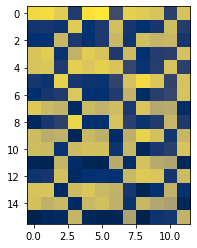

In [46]:
plt.imshow(ρ,cmap='cividis')
plt.show()

In [47]:
#normalize to obtain final ρ

Ns = sum(ρ)
for i in range(0,12):
    ρ[:,i] = ρ[:,i]/Ns[i]

In [48]:
#correlations

Sb = np.zeros((4,12))

for i in range(0,4):
    ib = format(i,'b').zfill(2)
    for j in range(0,12):
        for k in range(0,16):
            kb = format(k,'b').zfill(4)
            
            ac = 4*(float(kb[0])-0.5)*(float(kb[3])-0.5)
            
            if (kb[1:3]==ib):
                Sb[i,j] = Sb[i,j] + ρ[k,j]*ac

In [49]:
#game scores

Tb = np.zeros(4)

for i in range(0,4):
    b = format(i,'b').zfill(2)
    b1 = int(b[0])
    b2 = int(b[1])
    
    Tb[i] = Tb[i] + ((-1.0)**(b2))*(Sb[i,0]+Sb[i,1]) + ((-1.0)**b1)*(Sb[i,2]-Sb[i,3])
    Tb[i] = Tb[i] + ((-1.0)**b2)*(Sb[i,4]+Sb[i,5]) - ((-1.0)**(b1+b2))*(Sb[i,6]-Sb[i,7])
    Tb[i] = Tb[i] + ((-1.0)**b1)*(Sb[i,8]+Sb[i,9]) - ((-1.0)**(b1+b2))*(Sb[i,10]-Sb[i,11])

In [50]:
Tb

array([1.6454, 1.6132, 1.6427, 1.589 ])

Final score is given by

$$\mathcal{T} = \sum_{b}T_{b}$$

In [51]:
sum(Tb)

6.490300000000001

Theoretically, QM with complex numbers predicts $\mathcal{T} = 6\sqrt{2} \approx 8.49$.

In [52]:
np.sqrt(2)*6

8.485281374238571

Raw results are not terribly impressive, and traditional framework making use of only real numbers can yield $\mathcal{T}\leq 7.66$ (see [here](https://www.nature.com/articles/s41586-021-04160-4)). The next step is to assess whether basic error mitigation can improve the score on the quantum device. Below, we use the calibration runs to construct a calibration matrix.

In [53]:
nshots = 20000

N = 4
dictlist = []

Ntot = 2**N

qcountsbare = {}

for i in range(0,Ntot):
    x = format(i, "b")

    while (len(x)<N):
        x = '0'+x
    x = x[::-1]

    qcountsbare[x] = 0
    dictlist.append(x)

C = np.matrix(np.zeros((2**N,2**N)))

for i in range(0,2**N):
    row = {**qcountsbare, **mcounts[i]}
    for j in range(0,2**N):
        C[i,j] = row[dictlist[j]]/nshots

In [54]:
def errormit(dics,C,N,Nt):
    #invert matrix (pseudoinverse)
    Cin = np.linalg.pinv(C)
    
    #empty list to store dictionaries
    counts_mit = []
    
    #bare count dictionary to catch missing states
    Ntot = 2**N
    qcountsbare = {}
    for i in range(0,Ntot):
        x = format(i, "b")
        
        while (len(x)<N):
            x = '0'+x
        
        x = x[::-1]
        qcountsbare[x] = 0
        
    for j in range(0,Nt):
        counts = {**qcountsbare, **dics[j]}
        
        v = np.zeros(Ntot)
        
        for i in range(0,Ntot):
            x = format(i, "b")
        
            while (len(x)<N):
                x = '0'+x
        
            x = x[::-1]
            v[i] = counts[x]
            
        v = np.matmul(Cin,v)
        v = np.array(v)[0]
        
        newdict = {}
        for i in range(0,Ntot):
            x = format(i, "b")
        
            while (len(x)<N):
                x = '0'+x
        
            x = x[::-1]
            newdict[x] = v[i]
        
        counts_mit.append(newdict)
        
    return counts_mit

Apply calibration matrix to collected data. It is possible to use built-in operations in Qiskit to do this if the overall scheme is reworked. The present approach is fairly simple, but it <i>does</i> run the risk of generating negative probabilities ([quasiprobabilities](https://quantumcomputing.stackexchange.com/questions/18343/manual-measurement-error-mitigation-returning-a-negative-number-of-counts)). In the [arXiv manuscript](https://arxiv.org/abs/2205.01262), it is noted that this did not pose a problem in the present context. An optimization-based approach which avoids negative probabilities did not alter the results in a significant way.

In [55]:
countsm = errormit(counts,C,4,12)

In [56]:
ρc=np.zeros((16,12))

for i in range(0,12):
    counts1 = countsm[i]
    keylist = list(counts1.keys())
    for j in range(0,len(keylist)):
        state = keylist[j]
        
        ρc[int(state[::-1],2),i] = counts1[state]
        
Ns = sum(ρc)
for i in range(0,12):
    ρc[:,i] = ρc[:,i]/Ns[i]
    
    
Sb = np.zeros((4,12))

for i in range(0,4):
    ib = format(i,'b').zfill(2)
    for j in range(0,12):
        for k in range(0,16):
            kb = format(k,'b').zfill(4)
            
            ac = 4*(float(kb[0])-0.5)*(float(kb[3])-0.5)
            
            if (kb[1:3]==ib):
                Sb[i,j] = Sb[i,j] + ρc[k,j]*ac
                
Tb = np.zeros(4)

for i in range(0,4):
    b = format(i,'b').zfill(2)
    b1 = int(b[0])
    b2 = int(b[1])
    
    Tb[i] = Tb[i] + ((-1.0)**(b2))*(Sb[i,0]+Sb[i,1]) + ((-1.0)**b1)*(Sb[i,2]-Sb[i,3])
    Tb[i] = Tb[i] + ((-1.0)**b2)*(Sb[i,4]+Sb[i,5]) - ((-1.0)**(b1+b2))*(Sb[i,6]-Sb[i,7])
    Tb[i] = Tb[i] + ((-1.0)**b1)*(Sb[i,8]+Sb[i,9]) - ((-1.0)**(b1+b2))*(Sb[i,10]-Sb[i,11])
    
sum(Tb)

7.929451322122054

So error mitigation does bring the score above the real/complex threshold of 7.66.

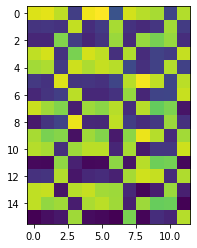

In [57]:
plt.imshow(ρc)
plt.show()